# Deeper Networks for Image Classification


## ResNet50 Model for CIFAR10 Image Classification

- Code by: Kaviraj Gosaye
- Student ID: 220575371

In [1]:
# GPU details
output = !nvidia-smi
for line in output:
    print(line)
    if line.strip() == "":
        break

Sun May  5 00:05:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   53C    P8             15W /  105W |     546MiB /   8192MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import psutil
# Get virtual memory information
virtual_memory = psutil.virtual_memory()
v_mem = virtual_memory.available / (1024 ** 3)

# Print available virtual memory
print("Available virtual memory:", v_mem)

Available virtual memory: 8.861900329589844


### 0. Imports

In [3]:
# import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from datetime import datetime

### 1. Data Loading and Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load CIFAR dataset
train_set = torchvision.datasets.CIFAR10(root='../datasets/CIFAR10', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='../datasets/CIFAR10', train=False, download=True, transform=transform)
                                    
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


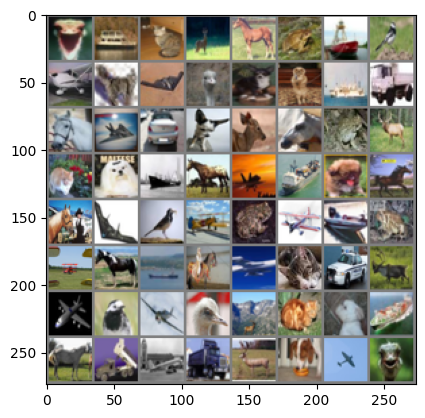

In [5]:
# extract one sample from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

# plot the image
def imshow(img):
    # reverse normalization
    img = img / 2 + 0.5
    # convert tensor to numpy array
    npimg = img.numpy()
    # rearrange the dimensions to match matplotlib format
    # matplotlib:   H x W x C
    # torch:        C x H x W
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))

### 2. Model Building

In [6]:
class Bottleneck(nn.Module):

    # self, input channels, number of channels for 3x3 conv, expansion factor, stride
    def __init__(self, in_channels, intermediate_channels, expansion, stride):

        super(Bottleneck,self).__init__()

        self.expansion = expansion
        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        
        # if identity mapping is possible
        if self.in_channels == self.intermediate_channels*self.expansion:
            self.identity = True
        # else projection mapping is required
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels*self.expansion, kernel_size=1, stride=stride, padding=0, bias=False ))
            projection_layer.append(nn.BatchNorm2d(self.intermediate_channels*self.expansion))
            self.projection = nn.Sequential(*projection_layer)

        self.relu = nn.ReLU()


        self.conv1_1x1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False )
        self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)
        
        self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
        self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)
        
        self.conv3_1x1 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False )
        self.batchnorm3 = nn.BatchNorm2d( self.intermediate_channels*self.expansion )
        
    def forward(self, x):
        # store input for pre-final layer
        in_x = x

        x = self.relu(self.batchnorm1(self.conv1_1x1(x)))

        x = self.relu(self.batchnorm2(self.conv2_3x3(x)))
        
        x = self.batchnorm3(self.conv3_1x1(x))

        # identity or projected mapping
        if self.identity:
            x += in_x
        else:
            x += self.projection(in_x)

        # final relu
        x = self.relu(x)
        
        return x

In [7]:
class ResNet50(nn.Module):
    # self, number of channels, image channels (3), output
    def __init__(self, resnet_channels, in_channels, num_classes):

        super(ResNet50,self).__init__()
        self.channels_list = resnet_channels[0]
        self.repeatition_list = resnet_channels[1]
        self.expansion = resnet_channels[2]

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False )
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.block1 = self.create_blocks( 64 , self.channels_list[0], self.repeatition_list[0], self.expansion, stride=1 )
        self.block2 = self.create_blocks( self.channels_list[0]*self.expansion , self.channels_list[1], self.repeatition_list[1], self.expansion, stride=2 )
        self.block3 = self.create_blocks( self.channels_list[1]*self.expansion , self.channels_list[2], self.repeatition_list[2], self.expansion, stride=2 )
        self.block4 = self.create_blocks( self.channels_list[2]*self.expansion , self.channels_list[3], self.repeatition_list[3], self.expansion, stride=2 )

        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear( self.channels_list[3]*self.expansion , num_classes)


    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.block1(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        
        x = self.block4(x)
        
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        
        x = self.fc1(x)
        
        return x

    # self, input channels, intermediate channels, number of repeats, expansion factor, stride
    def create_blocks(self, in_channels, intermediate_channels, num_repeat, expansion, stride):
        layers = [] 
        layers.append(Bottleneck(in_channels,intermediate_channels,expansion,stride=stride))
        for num in range(1,num_repeat):
            layers.append(Bottleneck(intermediate_channels*expansion,intermediate_channels,expansion,stride=1))

        return nn.Sequential(*layers)

In [8]:
# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [9]:
# creating instance of model and setting it to the device
architecture = ([64,128,256,512], [3,4,6,3], 4)
resnet_50 = ResNet50(architecture , in_channels=3, num_classes=10).to(device)

In [10]:
# visualize the model
info = summary(resnet_50, (1, 3, 32, 32), col_names = ('input_size', 'output_size', 'num_params', 'kernel_size'))
print(info)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
ResNet50                                 [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     [3, 3]
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           [1, 64, 32, 32]           128                       --
├─ReLU: 1-3                              [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           [1, 64, 16, 16]           --                        3
├─Sequential: 1-5                        [1, 64, 16, 16]           [1, 256, 16, 16]          --                        --
│    └─Bottleneck: 2-1                   [1, 64, 16, 16]           [1, 256, 16, 16]          --                        --
│    │    └

### 3. Model Training and Evaluation

In [11]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_50.parameters(), lr=0.0001, weight_decay=1e-5)

# open log file in write mode
log_file = open("../logs/resnet_50_cifar10_log.txt", "w")

start = time.time()

num_epochs = 50

train_losses = []
train_accs = []
test_losses = []
test_accs = []

test_correct = 0
total = 0

predicted_labels = []
true_labels = []


for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_test_loss = 0.0
    running_test_acc = 0.0
    correct = 0.0
    avg_test_loss = 0
    batch_loss = 0.0
    batch_acc = 0.0

    # setting the model to train mode
    resnet_50.train()
    
    # loop over the training set
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = resnet_50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # cumulative loss
        running_train_loss += loss.item()
        # batch loss for logging
        batch_loss += loss.item()

        # cumulative accuracy
        pred = outputs.argmax(dim=1, keepdim=True)

        # reshaping the labels to match the shape of the predictions
        # comparing the predictions to the labels using element-wise comparison
        # summing the correct predictions
        correct = pred.eq(labels.view_as(pred)).sum().item()
        running_train_acc += 100. * (correct / len(pred))

        # batch accuracy for logging
        batch_acc += 100. * (correct / len(pred))
        # printing the average loss every 100 mini-batches
        if i % 100 == 99:
             # Get current timestamp
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            # Write loss to log file
            log_file.write(f"{timestamp} - [{epoch + 1}, {i + 1}] loss: {batch_loss/100} accuracy: {batch_acc/100}\n")
            print(f"[{epoch + 1}, {i + 1}] loss: {batch_loss/100} accuracy: {batch_acc/100}")
            batch_loss = 0.0
            batch_acc = 0.0

    train_accs.append(running_train_acc/len(train_loader))
    train_losses.append(running_train_loss/len(train_loader))


    ##############################

    # setting the model to evaluation mode
    resnet_50.to(device)
    resnet_50.eval()


    # Disable gradient calculation
    with torch.no_grad():
        # Using test set
        for i, data in enumerate(test_loader, 0):

            images, labels = data[0].to(device), data[1].to(device)
            
            # Forward pass
            outputs = resnet_50(images)
            
            # Calculate the test loss
            loss = criterion(outputs, labels)
            avg_test_loss += loss.item()

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            
            # Update the total and correct predictions
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            # Append the predicted and true labels to be used for confusion matrix
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            running_test_loss += loss.item()
            running_test_acc += 100 * test_correct / total

           
        test_losses.append(running_test_loss/len(test_loader))
        test_accs.append(running_test_acc/len(test_loader))

training_time = f'{(time.time() - start)/60.0:.2f}'
log_file.write(f"Finished Training after {training_time} minutes\n")
print(f"Finished Training after {training_time} minutes")

# Close the log file
log_file.close()

[1, 100] loss: 2.1308843088150025 accuracy: 22.265625
[1, 200] loss: 1.833370110988617 accuracy: 33.171875
[1, 300] loss: 1.7000917160511018 accuracy: 37.28125
[1, 400] loss: 1.5926041722297668 accuracy: 41.65625
[1, 500] loss: 1.494006541967392 accuracy: 44.984375
[1, 600] loss: 1.4700204288959504 accuracy: 47.53125
[1, 700] loss: 1.421518268585205 accuracy: 48.296875
[2, 100] loss: 1.2177369284629822 accuracy: 55.828125
[2, 200] loss: 1.2431312376260757 accuracy: 55.578125
[2, 300] loss: 1.2170372551679611 accuracy: 55.875
[2, 400] loss: 1.2215346801280975 accuracy: 55.734375
[2, 500] loss: 1.158194767832756 accuracy: 58.109375
[2, 600] loss: 1.154552441239357 accuracy: 59.46875
[2, 700] loss: 1.1480709809064864 accuracy: 58.84375
[3, 100] loss: 0.9383580559492111 accuracy: 66.84375
[3, 200] loss: 0.9399823868274688 accuracy: 65.59375
[3, 300] loss: 0.9365349411964417 accuracy: 67.15625
[3, 400] loss: 0.9557415127754212 accuracy: 66.0
[3, 500] loss: 0.9611389201879501 accuracy: 65.40

In [12]:
# save model after training
torch.save(resnet_50, "../Models/resnet_50_cifar_10.pth")

### 4. Model Results and Plots

In [13]:
# print final accuracy
# get the final value of train_acc

print(f"Train Accuracy: {train_accs[-1]} %")
print(f"Test Accuracy: {test_accs[-1]} %")

print(f"Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Accuracy: 99.2746962915601 %
Test Accuracy: 73.57982195378973 %
Train Loss: 0.021017506657729654
Test Loss: 1.1841545467543755


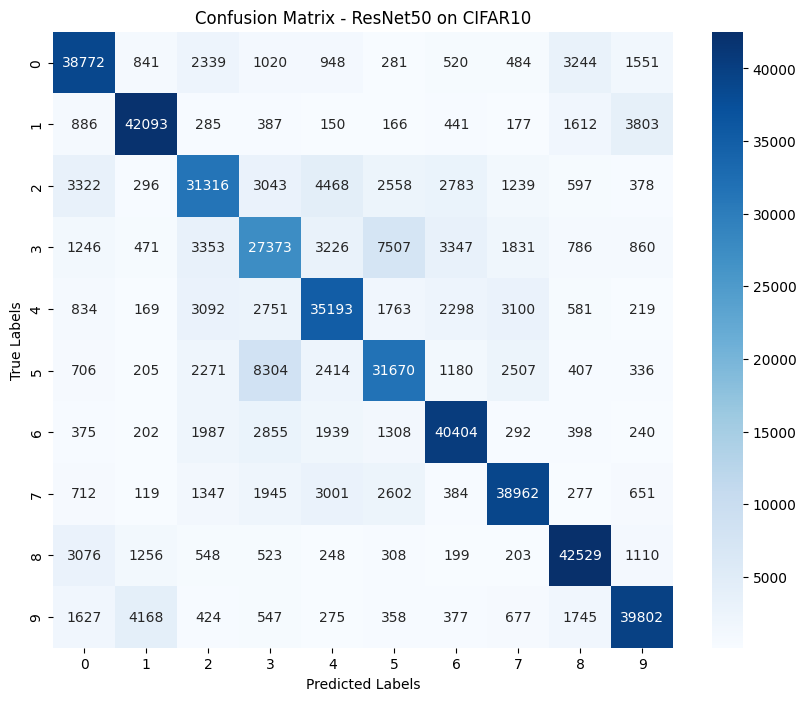

In [14]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - ResNet50 on CIFAR10")
plt.show()

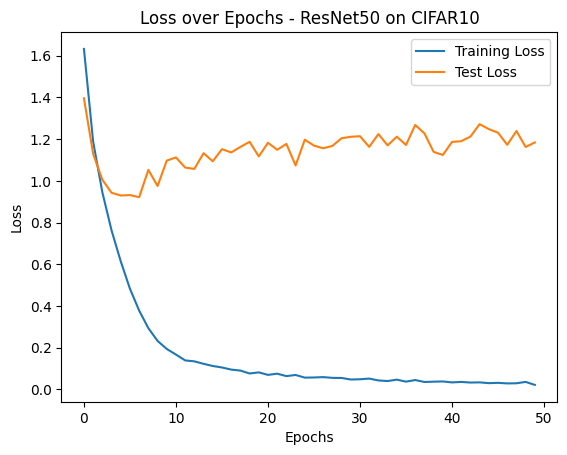

In [15]:
# plot the training loss and test loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs - ResNet50 on CIFAR10")
plt.legend()
# save the plot
plt.savefig("./plots/Loss_ResNet50_CIFAR10.png")
plt.show()

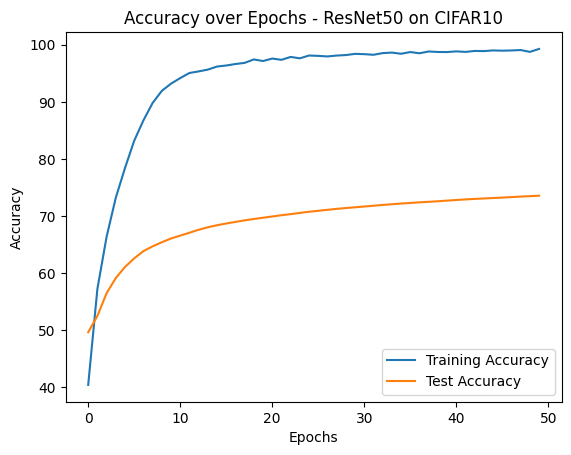

In [16]:
# plot the training accuracy and test accuracy over epochs
plt.plot(train_accs, label="Training Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs - ResNet50 on CIFAR10")
plt.legend()
plt.savefig("./plots/Acc_ResNet50_CIFAR10.png")
plt.show()

In [17]:
# print classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.78      0.76     50000
           1       0.84      0.84      0.84     50000
           2       0.67      0.63      0.65     50000
           3       0.56      0.55      0.55     50000
           4       0.68      0.70      0.69     50000
           5       0.65      0.63      0.64     50000
           6       0.78      0.81      0.79     50000
           7       0.79      0.78      0.78     50000
           8       0.82      0.85      0.83     50000
           9       0.81      0.80      0.80     50000

    accuracy                           0.74    500000
   macro avg       0.74      0.74      0.74    500000
weighted avg       0.74      0.74      0.74    500000



### 5. Model Testing

In [18]:
# loading some images from the test set
testloader = torch.utils.data.DataLoader(test_set, batch_size=30,shuffle=False)

dataiter = iter(testloader)
images, true_labels = next(dataiter)                        

In [19]:
# classes of CIFAR-10
classes = ('Plane', 'Car', 'Bird', 'Cat','Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

In [20]:
# plotter function to plot the images
def plotter(images, true_labels, predicted_labels):
    correct = 0
    num_images = len(images)
    num_rows = (num_images) // 5
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, 20))
    # setting the title
    fig.suptitle('True Label - [Predicted Labels]', fontsize=20)

    for ind in range(num_images):
        # plot image
        img = images[ind].permute(1, 2, 0) / 2 + 0.5
        ax = axs[ind // 5, ind % 5]
        ax.imshow(img)

        # left - true label, right - predicted label
        if classes[true_labels[ind]] == classes[predicted_labels[ind]]:
            color = 'green'
            title = classes[true_labels[ind]] + ' - [' + classes[predicted_labels[ind]] + ']'
            ax.set_title(title, color=color)
            correct += 1
        else:
            color = 'red'
            title = classes[true_labels[ind]] + ' - [' + classes[predicted_labels[ind]] + ']'
            ax.set_title(title, color=color)        

    plt.tight_layout(pad=2.0)
    plt.show()
    print('Number of correct predictions: ', correct)
    print('Number of wrong predictions: ', num_images - correct)

In [21]:
# use model to predict images label
resnet_50.eval()
resnet_50.to('cpu')
outputs = resnet_50(images)
_, predicted_labels = torch.max(outputs, 1)

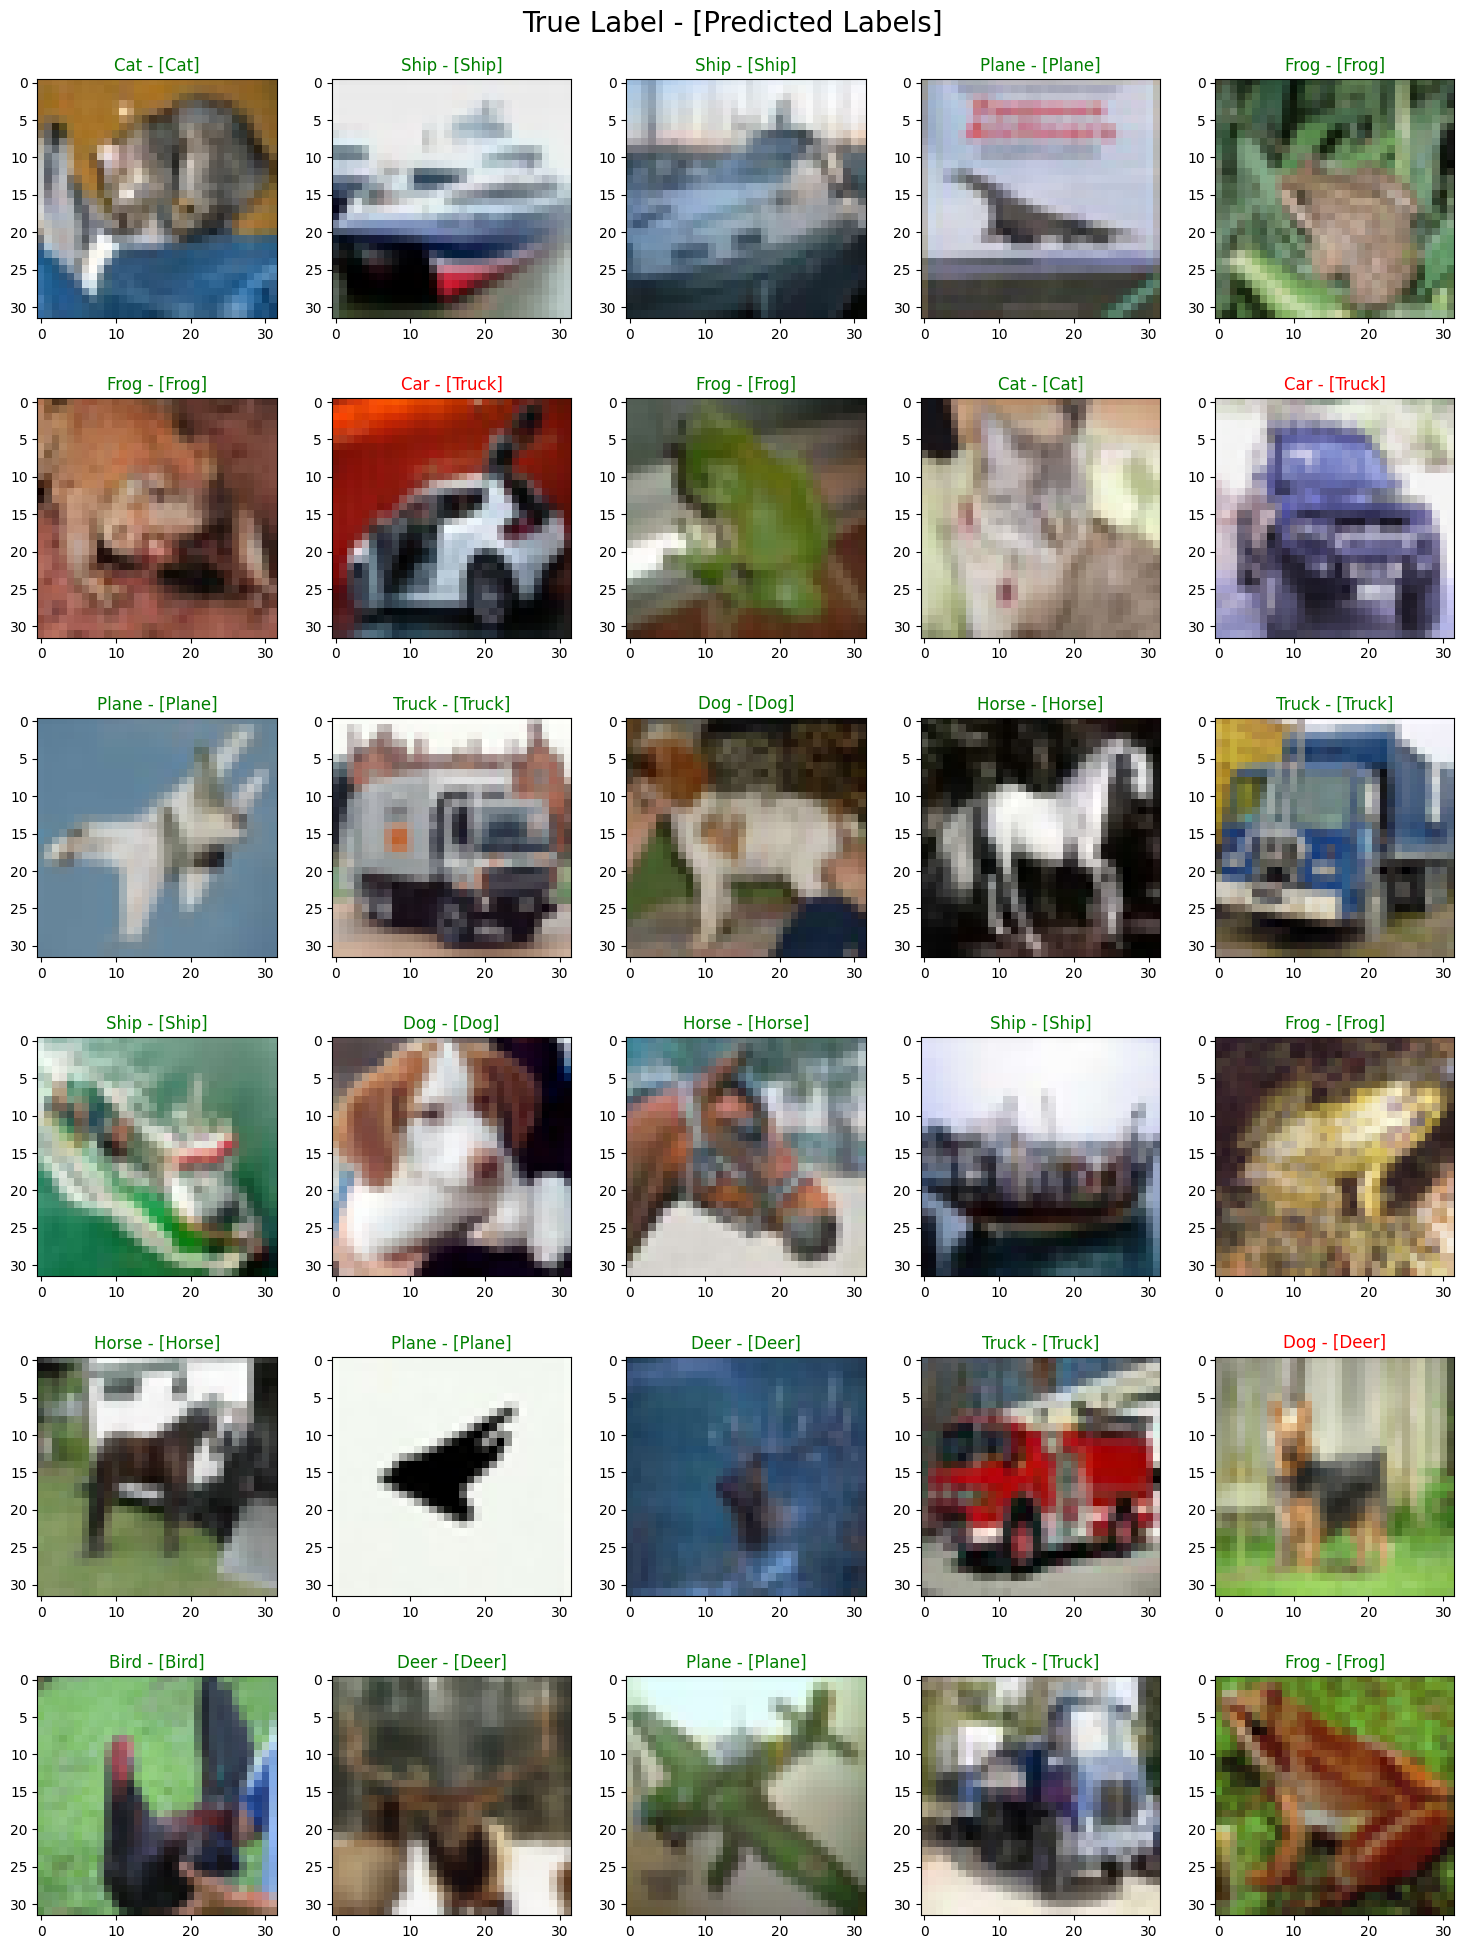

Number of correct predictions:  27
Number of wrong predictions:  3


In [22]:
# plot the images and predictions
plotter(images, true_labels, predicted_labels)